## Global settings and imports

In [10]:
%load_ext autoreload
%autoreload 2

import sys
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import optuna
from tqdm import tqdm
import torch.optim as optim

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings, generate_embeddings_with_transformers
from utils._python import write_submission_file, rank_predictions_by_score

from models_pytorch.nrms import NRMSModel
from models_pytorch.NRMSDocVecModel import NRMSDocVecModel

from transformers import AutoTokenizer, AutoModel
from models_pytorch.dataloader import NRMSDataSet
from models_pytorch.model_config import hparams_nrms_torch

# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version: 3.10.12
PyTorch version: 2.4.1+cu124
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU
Number of GPUs available: 1


## Prepare parameters

In [11]:
seed = 42
batch_size = 64

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

## Download and load data

In [12]:
DATASPLIT = "ebnerd_small"
PATH = Path(f"./{DATASPLIT}")  # Base path for your data directory
print(PATH)

HISTORY_SIZE = hparams_nrms_torch.__dict__['history_size']
FRACTION = 0.1

# # Debug print
articles_df = pl.read_parquet(PATH.joinpath("articles.parquet"))
# print("Columns in articles.parquet:")
# for col in articles_df.columns:
#     print(f"- {col}")

# print(articles_df.head(2))

ebnerd_small


In [34]:
from utils._constants import (
    DEFAULT_ARTICLE_ID_COL,
    DEFAULT_CATEGORY_COL,
    DEFAULT_HISTORY_CATEGORY_COL,
    DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_SENTIMENT_LABEL_COL,
    DEFAULT_SENTIMENT_SCORE_COL,
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
)


def ebnerd_from_path(path: Path, articles_df: pl.DataFrame, history_size: int = 30) -> pl.DataFrame:
    # Create lookup dictionaries with default values
    category_dict = dict(zip(
        articles_df[DEFAULT_ARTICLE_ID_COL],
        articles_df[DEFAULT_CATEGORY_COL]
    ))
    
    sentiment_score_dict = dict(zip(
        articles_df[DEFAULT_ARTICLE_ID_COL],
        articles_df[DEFAULT_SENTIMENT_SCORE_COL]
    ))
    
    sentiment_label_dict = dict(zip(
        articles_df[DEFAULT_ARTICLE_ID_COL],
        articles_df[DEFAULT_SENTIMENT_LABEL_COL]
    ))

    def safe_lookup_list(ids, lookup_dict, default_value):
            if ids is None:
                return [default_value]  # Return list with default instead of empty list
            return [lookup_dict.get(id_, default_value) for id_ in ids]

    # Load history
    print("Loading history...")
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select([
            DEFAULT_USER_COL,
            DEFAULT_HISTORY_ARTICLE_ID_COL,
            DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
        ])
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            enable_warning=False,
        )
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
            history_size=history_size,
            enable_warning=False,
        )
        .collect()
    )

    print("Adding features to history...")
    df_history = df_history.with_columns([
        pl.col(DEFAULT_HISTORY_ARTICLE_ID_COL)
        .map_elements(
            lambda ids: safe_lookup_list(ids, category_dict, -1),
            return_dtype=pl.List(pl.Int16)
        )
        .alias(DEFAULT_HISTORY_CATEGORY_COL)
    ])

    # Verify history data
    print("\nHistory data verification:")
    first_history = df_history.head(1)
    print(f"History columns: {df_history.columns}")
    if len(first_history) > 0:
        print(f"First row article IDs: {first_history[DEFAULT_HISTORY_ARTICLE_ID_COL][0][:5]}...")
        print(f"First row categories: {first_history[DEFAULT_HISTORY_CATEGORY_COL][0][:5]}...")

    # Join with behaviors
    print("\nJoining with behaviors...")
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history,
            on=DEFAULT_USER_COL,
            how="left",
        )
    )

    # Add inview features
    print("Adding inview features...")
    df_behaviors = df_behaviors.with_columns([
        pl.col(DEFAULT_INVIEW_ARTICLES_COL)
        .map_elements(
            lambda ids: safe_lookup_list(ids, category_dict, -1),
            return_dtype=pl.List(pl.Int16)
        )
        .alias("inview_categories"),
        
        pl.col(DEFAULT_INVIEW_ARTICLES_COL)
        .map_elements(
            lambda ids: safe_lookup_list(ids, sentiment_score_dict, 0.0),
            return_dtype=pl.List(pl.Float32)
        )
        .alias("inview_sentiment_scores"),
        
        pl.col(DEFAULT_INVIEW_ARTICLES_COL)
        .map_elements(
            lambda ids: safe_lookup_list(ids, sentiment_label_dict, "unknown"),
            return_dtype=pl.List(pl.Utf8)
        )
        .alias("inview_sentiment_labels")
    ])

    # Final verification
    print("\nFinal verification:")
    print(f"Columns in final dataframe: {df_behaviors.columns}")
    first_row = df_behaviors.head(1)
    if len(first_row) > 0:
        for col in [DEFAULT_HISTORY_CATEGORY_COL, "inview_categories", "inview_sentiment_scores"]:
            if col in first_row.columns:
                val = first_row[col][0]
                print(f"{col}: {type(val)} - {val[:5] if val is not None else 'None'}")

    # After creating df_train, add these verification prints:
    print("\nDetailed Data Verification:")
    print("-" * 50)
    sample_row = df_train.head(1)

    # 1. Check history data alignment
    history_ids = sample_row[DEFAULT_HISTORY_ARTICLE_ID_COL][0]
    history_cats = sample_row[DEFAULT_HISTORY_CATEGORY_COL][0]
    print("\nHistory Verification:")
    print(f"First 3 history articles and their categories:")
    for i in range(min(3, len(history_ids))):
        print(f"Article ID: {history_ids[i]} -> Category: {history_cats[i]}")
    print(f"Total history length: {len(history_ids)}")

    # 2. Check inview data alignment
    inview_ids = sample_row[DEFAULT_INVIEW_ARTICLES_COL][0]
    inview_cats = sample_row['inview_categories'][0]
    inview_sentiments = sample_row['inview_sentiment_scores'][0]
    print("\nInview Articles Verification:")
    print(f"First 3 inview articles and their features:")
    for i in range(min(3, len(inview_ids))):
        print(f"Article ID: {inview_ids[i]}")
        print(f"-> Category: {inview_cats[i]}")
        print(f"-> Sentiment: {inview_sentiments[i]}")
    print(f"Total inview length: {len(inview_ids)}")

    # 3. Verify the raw dictionary mappings
    print("\nDictionary Verification:")
    test_article_id = history_ids[0]
    print(f"Test article {test_article_id}:")
    print(f"Category from dict: {category_dict.get(test_article_id, 'Not found')}")
    print(f"Category in data: {history_cats[0]}")

    return df_behaviors

# Load articles data
articles_df = pl.read_parquet(PATH.joinpath("articles.parquet"))

# Update columns to include new features
COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_HISTORY_CATEGORY_COL,
    DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    "inview_categories",
    "inview_sentiment_scores",
    "inview_sentiment_labels"
]

# Load train data
df_train = (
    ebnerd_from_path(PATH.joinpath("train"), articles_df, history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)

# Load validation data
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), articles_df, history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)

# Verification prints
print("\nTraining Data Verification:")
print("-" * 50)
print(f"Number of samples: {len(df_train)}")
sample_row = df_train.head(1)
print("\nSample row:")
print(f"History categories length: {len(sample_row[DEFAULT_HISTORY_CATEGORY_COL][0])}")
print(f"Inview articles length: {len(sample_row[DEFAULT_INVIEW_ARTICLES_COL][0])}")
print(f"Inview categories length: {len(sample_row['inview_categories'][0])}")
print(f"Inview sentiment scores length: {len(sample_row['inview_sentiment_scores'][0])}")
print(f"Inview sentiment labels length: {len(sample_row['inview_sentiment_labels'][0])}")

print("\nSample values for first inview article:")
print(f"Category: {sample_row['inview_categories'][0][0]}")
print(f"Sentiment score: {sample_row['inview_sentiment_scores'][0][0]}")
print(f"Sentiment label: {sample_row['inview_sentiment_labels'][0][0]}")

print("\nValidation Data Verification:")
print("-" * 50)
print(f"Number of samples: {len(df_validation)}")

Loading history...
Adding features to history...

History data verification:
History columns: ['user_id', 'article_id_fixed', 'impression_time_fixed', 'category_fixed']
First row article IDs: shape: (5,)
Series: '' [i32]
[
	9766862
	9766886
	9766944
	9762678
	9766695
]...
First row categories: shape: (5,)
Series: '' [i16]
[
	118
	118
	118
	142
	414
]...

Joining with behaviors...
Adding inview features...

Final verification:
Columns in final dataframe: ['impression_id', 'article_id', 'impression_time', 'read_time', 'scroll_percentage', 'device_type', 'article_ids_inview', 'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'session_id', 'next_read_time', 'next_scroll_percentage', 'article_id_fixed', 'impression_time_fixed', 'category_fixed', 'inview_categories', 'inview_sentiment_scores', 'inview_sentiment_labels']
category_fixed: <class 'polars.series.series.Series'> - shape: (5,)
Series: '' [i16]
[
	118
	118
	414
	118
	118
]
inview_categori

In [35]:
from utils._constants import DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL


article_lengths = df_train[DEFAULT_HISTORY_ARTICLE_ID_COL].list.len()
time_lengths = df_train[DEFAULT_HISTORY_IMPRESSION_TIMESTAMP_COL].list.len()
print("Do lengths match?", (article_lengths == time_lengths).all())

Do lengths match? True


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Validation dataset sizes:
Original: 24464 records
Filtered: 23031 records
Removed: 1433 records


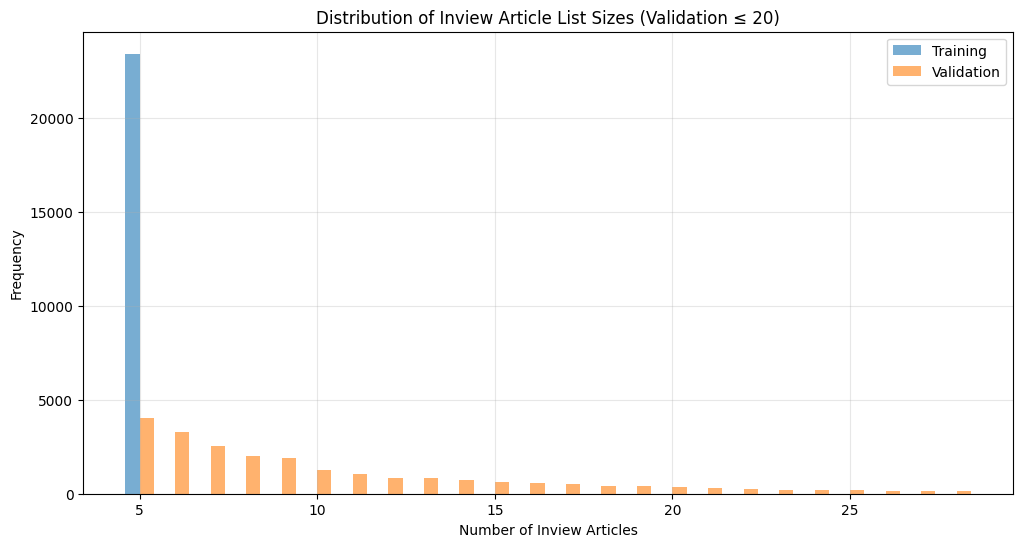


Training Data Statistics:
Mean: 5.00
Median: 5.00
Min: 5
Max: 5

Filtered Validation Data Statistics:
Mean: 10.19
Median: 8.00
Min: 5
Max: 28


In [36]:
# Filter validation data
df_validation_filtered = df_validation.filter(
    pl.col(DEFAULT_INVIEW_ARTICLES_COL).map_elements(lambda x: len(x) <= 28)
)

print("Validation dataset sizes:")
print(f"Original: {len(df_validation)} records")
print(f"Filtered: {len(df_validation_filtered)} records")
print(f"Removed: {len(df_validation) - len(df_validation_filtered)} records")

# Calculate distributions
train_lengths = [len(row) for row in df_train[DEFAULT_INVIEW_ARTICLES_COL]]
valid_lengths = [len(row) for row in df_validation_filtered[DEFAULT_INVIEW_ARTICLES_COL]]

# Create visualization
plt.figure(figsize=(12, 6))
plt.bar(pd.Series(train_lengths).value_counts().sort_index().index - 0.2, 
        pd.Series(train_lengths).value_counts().sort_index().values, 
        width=0.4, label='Training', alpha=0.6)
plt.bar(pd.Series(valid_lengths).value_counts().sort_index().index + 0.2, 
        pd.Series(valid_lengths).value_counts().sort_index().values, 
        width=0.4, label='Validation', alpha=0.6)

plt.xlabel('Number of Inview Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Inview Article List Sizes (Validation ≤ 20)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nTraining Data Statistics:")
print(f"Mean: {np.mean(train_lengths):.2f}")
print(f"Median: {np.median(train_lengths):.2f}")
print(f"Min: {min(train_lengths)}")
print(f"Max: {max(train_lengths)}")

print("\nFiltered Validation Data Statistics:")
print(f"Mean: {np.mean(valid_lengths):.2f}")
print(f"Median: {np.median(valid_lengths):.2f}")
print(f"Min: {min(valid_lengths)}")
print(f"Max: {max(valid_lengths)}")

In [37]:
def calculate_average_length(df, column):
    total_length = sum(len(row) for row in df[column])
    average_length = total_length / len(df)
    return average_length

# Calculate average length for df_train
average_length_inview_train = calculate_average_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_train: {average_length_inview_train}")

# Calculate average length for df_validation
average_length_inview_validation = calculate_average_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_validation: {average_length_inview_validation}")

Average length of article_ids_inview in df_train: 5.0
Average length of article_ids_inview in df_validation: 11.962066710268148


In [38]:
# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 88
Longest history length in df_train: 50
Longest history length in df_validation: 50


In [39]:
# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 23427
Number of rows with exactly one clicked article in df_validation: 24327


In [28]:
df_validation.head()

user_id,article_id_fixed,category_fixed,article_ids_inview,article_ids_clicked,impression_id,inview_categories,inview_sentiment_scores,inview_sentiment_labels,labels
i64,list[i64],list[i64],list[i64],list[i64],i64,list[i64],list[f64],list[str],list[i64]
973321,"[9772389, 9772389, … 9779427]","[2975, 2975, … 414]","[9786557, 9787501, … 9783891]",[9787768],398891243,"[457, 142, … 414]","[0.7606, 0.8836, … 0.7683]","[""Positive"", ""Neutral"", … ""Neutral""]","[0, 0, … 0]"
2530683,"[9774532, 9774789, … 9780020]","[142, 118, … 118]","[9788251, 9788760, … 9788621]",[9788404],247632331,"[414, 142, … 140]","[0.6278, 0.733, … 0.6957]","[""Neutral"", ""Neutral"", … ""Negative""]","[0, 0, … 0]"
2453083,"[9771051, 9772275, … 9779541]","[457, 457, … 118]","[9484153, 9788125, … 9788521]",[9788125],377228761,"[414, 457, … 512]","[0.8469, 0.8349, … 0.8661]","[""Neutral"", ""Neutral"", … ""Positive""]","[0, 1, … 0]"
87107,"[9776916, 9776916, … 9780019]","[118, 118, … 142]","[9789493, 8164080, … 9790475]",[8164080],317241518,"[572, 118, … 414]","[0.6946, 0.8378, … 0.5618]","[""Neutral"", ""Negative"", … ""Neutral""]","[0, 1, … 0]"
1757180,"[9758869, 9760675, … 9779642]","[118, 140, … 414]","[9789676, 9790040, … 9789837]",[9789702],413439143,"[118, 512, … 414]","[0.9027, 0.6598, … 0.8666]","[""Neutral"", ""Neutral"", … ""Positive""]","[0, 0, … 0]"


In [29]:
print(f"Number of users in df_train: {df_train['user_id'].n_unique()}")

Number of users in df_train: 8914


In [30]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(10)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""
3012771,"""Morten Bruun fyret i Sønderjys…","""FODBOLD: Morten Bruun fyret me…",2023-06-29 06:20:39,false,"""Kemien mellem spillerne i Supe…",2006-05-01 14:28:40,[3177953],"""article_default""","""https://ekstrabladet.dk/sport/…",[],[],"[""Erhverv"", ""Kendt"", … ""Ansættelsesforhold""]",142,"[196, 199]","""sport""",null,null,null,0.8241,"""Negative"""
3023463,"""Luderne flytter på landet""","""I landets tyndest befolkede om…",2023-06-29 06:20:43,false,"""Det frække erhverv rykker på l…",2007-03-24 08:27:59,[3184029],"""article_default""","""https://ekstrabladet.dk/nyhede…",[],[],"[""Livsstil"", ""Erotik""]",118,[133],"""nyheder""",null,null,null,0.7053,"""Neutral"""
3032577,"""Cybersex: Hvornår er man utro?""","""En flirtende sms til den flott…",2023-06-29 06:20:46,false,"""De fleste af os mener, at et t…",2007-01-18 10:30:37,[3030463],"""article_default""","""https://ekstrabladet.dk/sex_og…",[],[],"[""Livsstil"", ""Partnerskab""]",565,[],"""sex_og_samliv""",null,null,null,0.9307,"""Neutral"""
3033563,"""Kniven for struben-vært får se…","""I aftenens udgave af 'Med kniv…",2023-06-29 06:20:47,false,"""Når man ser fjerde program i T…",2007-03-27 10:22:08,"[3005524, 3005525]","""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Livsstil"", ""Underholdning"", … ""Mad og drikke""]",414,"[433, 436]","""underholdning""",null,null,null,0.9371,"""Neutral"""
3034608,"""Willy Strube har begået selvmo…","""Den tidligere SiD-chef tog sit…",2023-06-29 06:20:49,false,"""Den tidligere formand for Indu…",2001-10-19 12:30:00,[3204848],"""article_default""","""https://ekstrabladet.dk/nyhede…","[""Willy Strube"", ""Willy Strube"", ""Willy Strube""]","[""PER"", ""PER"", ""PER""]","[""Kriminalitet"", ""Erhverv"", … ""Offentlig instans""]",118,[130],"""nyheder""",null,null,null,0.9971,"""Negative"""
3034849,"""Venner for livet""","""VK-REGERINGEN""",2023-06-29 06:20:50,false,"""VK-REGERINGEN håndplukkede Bjø…",2003-01-09 06:00:00,null,"""article_default""","""https://ekstrabladet.dk/incomi…",[],[],"[""Kendt"", ""Politik"", ""National politik""]",2,[],"""incoming""",null,null,null,0.8454,"""Neutral"""
3035648,"""Dronning af escort-branchen""","""Trine Michelsen hjælper københ…",2023-06-29 06:20:52,false,"""En af escortbranchens største …",2003-06-17 07:10:00,[3082573],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Erhverv"", ""Livsstil"", … ""Erotik""]",140,[],"""krimi""",null,null,null,0.8814,"""Neutral"""


In [ ]:
# TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
# TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL]
# MAX_TITLE_LENGTH = 30

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

# # LOAD HUGGINGFACE and move to device immediately:
# transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME).to(device)
# transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

## Embedding tokenized article title

In [40]:
# Load the document vector parquet file
document_vector_path = Path("Ekstra_Bladet_word2vec/document_vector.parquet")
df_document_vector = pl.read_parquet(document_vector_path)

# Display the first few rows of the dataframe

article_mapping = create_article_id_to_value_mapping(df=df_document_vector, value_col="document_vector")

In [ ]:
# from tqdm import tqdm
# from utils._python import batch_items_generator


# BATCH_SIZE = 32
# n_batches = int(np.ceil(df_articles.height / BATCH_SIZE))

# chunked_text_list = batch_items_generator(df_articles[DEFAULT_TITLE_COL].to_list(), BATCH_SIZE)
# embeddings = (
#     generate_embeddings_with_transformers(
#         model=transformer_model,
#         tokenizer=transformer_tokenizer,
#         text_list=text_list,
#         batch_size=BATCH_SIZE,
#         disable_tqdm=True,
#     )
#     for text_list in tqdm(
#         chunked_text_list, desc="Encoding", total=n_batches, unit="text"
#     )
# )
# embeddings = torch.vstack(list(embeddings))

## Reduce dimensionality of embeddings

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.metrics import explained_variance_score
# import numpy as np

# def reduce_and_analyze_dimensionality(embeddings_array, target_dims=[24, 32, 64, 128, 256]):
#     """
#     Reduce dimensionality using different methods and analyze information retention
#     """
#     results = {}
    
#     # PCA Analysis for different dimensions
#     for dim in target_dims:
#         # PCA
#         pca = PCA(n_components=dim)
#         reduced_data_pca = pca.fit_transform(embeddings_array)
        
#         # Calculate explained variance ratio
#         explained_var = np.sum(pca.explained_variance_ratio_) * 100
        
#         results[dim] = {
#             'method': 'PCA',
#             'explained_variance_ratio': explained_var,
#             'reduced_data': reduced_data_pca
#         }
        
#         print(f"\nDimensionality Reduction to {dim} dimensions:")
#         print(f"Explained variance ratio (PCA): {explained_var:.2f}%")
#         print(f"Shape after reduction: {reduced_data_pca.shape}")

#     return results

# # Convert embeddings to numpy array if it's not already
# embeddings_numpy = embeddings.cpu().numpy()

# # Analyze different dimensionality reductions
# reduction_results = reduce_and_analyze_dimensionality(embeddings_numpy)

# # Choose the dimension that provides good balance 
# # between compression and information retention
# chosen_dim = hparams_nrms_torch.__dict__['embedding_dim']  # Adjust based on analysis results
# pca = PCA(n_components=chosen_dim)
# reduced_embeddings = pca.fit_transform(embeddings_numpy)

# # Update the dataframe with reduced embeddings
# embedded_title = f"{DEFAULT_TITLE_COL}_embedded_reduced"
# df_articles = df_articles.with_columns(pl.Series(embedded_title, reduced_embeddings))

# # Create new article mapping with reduced embeddings
# article_mapping = create_article_id_to_value_mapping(
#     df=df_articles, value_col=embedded_title
# )

# Init dataloaders



In [41]:
train_dataset = NRMSDataSet(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    eval_mode=False,
)

val_dataset = NRMSDataSet(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    eval_mode=True,
)

Starting preprocessing...
Preprocessing data...
(23427, 12)
Data preprocessing completed in 6.99 seconds.
Starting preprocessing...
Preprocessing data...
(24327, 12)
Data preprocessing completed in 7.76 seconds.


In [42]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn_with_global_padding(batch, max_len_pred, apply_padding_to_targets=True):
    try:
        his_input_titles = [item[0][0] for item in batch]
        his_timestamps = [item[0][1] for item in batch]
        pred_input_titles = [item[0][2] for item in batch]
        batch_ys = [item[1] for item in batch]
        impression_id = torch.tensor([item[2] for item in batch], dtype=torch.int64)

        # Pad sequences
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)
        his_timestamps_padded = pad_sequence(his_timestamps, batch_first=True, padding_value=0)
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        
        if pred_input_titles_padded.size(1) < max_len_pred:
            pad_size = max_len_pred - pred_input_titles_padded.size(1)
            pred_input_titles_padded = torch.nn.functional.pad(
                pred_input_titles_padded, (0, 0, 0, pad_size), value=0
            )
        elif pred_input_titles_padded.size(1) > max_len_pred:
            pred_input_titles_padded = pred_input_titles_padded[:, :max_len_pred, :]

        if apply_padding_to_targets:
            batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=-1)
            if batch_ys_padded.size(1) < max_len_pred:
                pad_size = max_len_pred - batch_ys_padded.size(1)
                batch_ys_padded = torch.nn.functional.pad(
                    batch_ys_padded, (0, pad_size), value=-1
                )
            elif batch_ys_padded.size(1) > max_len_pred:
                batch_ys_padded = batch_ys_padded[:, :max_len_pred]
            return (his_input_titles_padded, his_timestamps_padded, pred_input_titles_padded), batch_ys_padded, impression_id
        else:
            return (his_input_titles_padded, his_timestamps_padded, pred_input_titles_padded), batch_ys, impression_id
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise


In [43]:
# Wrap the dataset with DataLoader
train_dataloader_temp = DataLoader(
    train_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

val_dataloader_temp = DataLoader(
    val_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

In [ ]:
# for batch in val_dataloader_temp:

#     (his_input_titles_padded, time_stamps, pred_input_titles_padded), batch_ys_padded, impression_id = batch
#     print(his_input_titles_padded[0].shape)  # Look at one padded sequence
#     print(time_stamps[0].shape)  # Look at one padded sequence
#     print(pred_input_titles_padded[0].shape)  # Look at one padded sequence
#     print(batch_ys_padded[0].shape)  # Look at one padded sequence

#     print("Batch loaded successfully!")
#     break

for batch in train_dataloader_temp:
    (his_input_titles_padded, time_stamps, pred_input_titles_padded), batch_ys_padded, impression_id = batch
    print(his_input_titles_padded.shape)  # Look at one padded sequence
    print(time_stamps.shape)  # Look at one padded sequence
    print(pred_input_titles_padded.shape)  # Look at one padded sequence
    print(batch_ys_padded.shape)  # Look at one padded sequence
    print(impression_id)

    print("Batch loaded successfully!")
    break


torch.Size([64, 50, 300])
torch.Size([64, 50])
torch.Size([64, 99, 300])
torch.Size([64, 99])
tensor([524869903, 451919853, 520699035, 261751793,  63515311, 369278561,
        375275181, 114146339, 204600968, 549293039, 388460366, 558616914,
        569708725,  56081518, 434922084, 418836386, 441645038, 519402611,
         34324945,  19094556, 556582237, 507883906, 318239002, 228081877,
        296163772, 259748755, 181578800, 358871256,   2099653, 183621801,
        370973727, 463862579,  62431328,  69946217, 545594394, 414142937,
        349743039, 292655250, 279318847, 140938854, 194095065, 563716230,
        490501776, 478941047, 141905959, 556690304, 385226029, 187152818,
        499696960, 397418248, 125097707, 469882860,  40660999, 157072759,
        306757482, 387572935, 507748360,  71715490, 444649695,  80925607,
        576868774, 309860337, 417971097, 312735590])
Batch loaded successfully!


In [ ]:
# # THIS CODE SHOULD ONLY RUN WHEN GENERATING THE DATA FOR THE FIRST TIME
# import torch
# from tqdm import tqdm

# # Function to preprocess and save data
# def preprocess_and_save(dataloader, filepath, device="cuda"):
#     all_inputs_his = []
#     all_inputs_pred = []
#     all_targets = []
#     all_impression_ids = []

#     # Iterate over DataLoader and collect data
#     for (his_inputs, pred_inputs), targets, impressionID in tqdm(dataloader, desc="Processing Data"):
#         all_inputs_his.append(his_inputs)
#         all_inputs_pred.append(pred_inputs)
#         all_targets.append(targets)
#         all_impression_ids.append(impressionID)

#     # Concatenate all batches into a single tensor
#     all_inputs_his = torch.cat(all_inputs_his).to(device)
#     all_inputs_pred = torch.cat(all_inputs_pred).to(device)
#     all_targets = torch.cat(all_targets).to(device)
#     all_impression_ids = torch.cat(all_impression_ids).to(device)

#     # Save the preprocessed data as a tuple
#     torch.save((all_inputs_his, all_inputs_pred, all_targets, all_impression_ids), filepath)
#     print(f"Data saved to {filepath}")

# # Save train and validation data
# preprocess_and_save(val_dataloader_temp, "val_data_small_dataset_with_impression_ids.pt", device="cuda")

# preprocess_and_save(train_dataloader_temp, "train_data_small_dataset_with_impression_ids.pt", device="cuda")


In [ ]:
# def load_preprocessed_data(filepath, device="cuda"):
#     # Load the data from the .pt file
#     data = torch.load(filepath)

#     # Unpack the data
#     his_inputs, pred_inputs, targets, impression_ids = data

#     # Move the data to the specified device
#     his_inputs = his_inputs.to(device, non_blocking=True)
#     pred_inputs = pred_inputs.to(device, non_blocking=True)
#     targets = targets.to(device, non_blocking=True)
#     impression_ids = impression_ids.to(device, non_blocking=True)

#     return his_inputs, pred_inputs, targets, impression_ids

# # Example: Load train and validation data
# device = "cuda" if torch.cuda.is_available() else "cpu"
# train_his_inputs, train_pred_inputs, train_targets, impression_ids = load_preprocessed_data("train_data_small_dataset_with_impression_ids.pt", device)
# val_his_inputs, val_pred_inputs, val_targets, impression_ids = load_preprocessed_data("val_data_small_dataset_with_impression_ids.pt", device)


In [ ]:
# def create_batches(inputs, targets, impression_ids, batch_size):
#     his_inputs, pred_inputs = inputs
#     for i in range(0, his_inputs.size(0), batch_size):
#         his_batch = his_inputs[i:i+batch_size]
#         pred_batch = pred_inputs[i:i+batch_size]
#         target_batch = targets[i:i+batch_size]
#         impression_id_batch = impression_ids[i:i+batch_size]
#         yield (his_batch, pred_batch), target_batch, impression_id_batch

# # Set the batch size
# batch_size = 64

# # Example: Create batches for train and validation data
# #train_batches = create_batches((train_his_inputs, train_pred_inputs), train_targets, batch_size)
# #val_batches = create_batches((val_his_inputs, val_pred_inputs), val_targets, batch_size)

# train_batches = list(create_batches((train_his_inputs, train_pred_inputs), train_targets, impression_ids, batch_size))
# val_batches = list(create_batches((val_his_inputs, val_pred_inputs), val_targets, impression_ids, batch_size))

In [ ]:
# for (his_batch, pred_batch), target_batch, impression_ids_batch in train_batches:
#     print(f"his_batch device: {his_batch.device}")
#     print(f"pred_batch device: {pred_batch.device}")
#     print(f"target_batch device: {target_batch.device}")
#     print(f"impression_ids_batch device: {impression_ids_batch.device}")
#     break


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Create hyper-parameters

In [ ]:
# see the model parameters: 
# print(hparams_nrms.__dict__)

## Create the NRMS model

In [44]:
import os
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve by a given percentage over a patience period."""
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved by min_delta.
            min_delta (float): Minimum percentage improvement required to reset patience.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta  # Minimum percentage improvement
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            # Initialize best_loss with the first validation loss
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss < self.best_loss * (1 - self.min_delta):
            # Significant improvement found
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved by at least {self.min_delta*100:.1f}%")
        else:
            # No significant improvement
            self.counter += 1
            if self.verbose:
                print(f"No significant improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

2024-12-13 10:52:40.783187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734083560.862424   15993 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734083560.887794   15993 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 10:52:41.047652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# # 1. Print model architecture
# print(model)

# # 2. Print specific layer sizes
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()}")

# # 3. Get total number of parameters
# total_params = sum(p.numel() for p in model.parameters())
# print(f"\nTotal parameters: {total_params:,}")

# # 4. Print layer by layer with shapes
# def print_model_structure(model):
#     print("\nDetailed Model Structure:")
#     for name, module in model.named_children():
#         print(f"\nLayer: {name}")
#         print(f"Type: {type(module).__name__}")
#         if hasattr(module, 'weight'):
#             print(f"Shape: {module.weight.shape}")

## Hyperoptimization

In [ ]:
# NUM_EPOCHS = 100

# def objective(trial):
#     # Small search space for head_num and head_dim
#     head_num = trial.suggest_categorical('head_num', [8, 16, 32])
#     head_dim = trial.suggest_categorical('head_dim', [16, 32, 48, 64])
    
#     base_dim = head_num * head_dim
    
#     # attention_hidden_dim equals base_dim for simplicity
#     attention_hidden_dim = base_dim
    
#     # units_per_layer chosen from [128, 256, 512]
#     # One possible interpretation: choose each layer size from this set.
#     units_per_layer = [
#         trial.suggest_categorical(f'unit_layer_{i}', [128, 256, 512]) 
#         for i in range(3)
#     ]
    
#     # Dropout discrete steps: [0.1, 0.2, 0.3, 0.4, 0.5]
#     dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])
    
#     # Learning rate: {1e-3, 1e-4, 1e-5}
#     learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-4, 1e-5])
    
#     # Weight decay: {1e-3, 1e-4}
#     weight_decay = trial.suggest_categorical('weight_decay', [1e-3, 1e-4])
    
#     hparams_optimize = {
#         'head_num': head_num,
#         'head_dim': head_dim,
#         'attention_hidden_dim': attention_hidden_dim,
#         'embedding_dim': 24,  # Assume fixed embedding dimension
#         'dropout': dropout,
#         'learning_rate': learning_rate,
#         'news_output_dim': base_dim,
#         'units_per_layer': units_per_layer,
#         'weight_decay': weight_decay,
#         'history_size': 50,  # can be fixed or chosen from a small set if desired
#     }

#     # Initialize model and training components
#     model = NRMSDocVecModel(hparams=hparams_optimize, device=device)
#     criterion = model.get_loss().to(device)
#     optimizer = optim.Adam(
#         model.parameters(), 
#         lr=hparams_optimize['learning_rate'], 
#         weight_decay=hparams_optimize['weight_decay']
#     )
    
#     early_stopping = EarlyStopping(patience=5, min_delta=0.03, verbose=True)
#     best_val_loss = float('inf')

#     for epoch in range(NUM_EPOCHS):
#         model.train()
#         train_loss = train_one_epoch(model, train_dataloader_temp, optimizer, criterion)
        
#         model.eval()
#         val_loss = validate(model, val_dataloader_temp, criterion)
        
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss

#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print(f"Early stopping triggered at epoch {epoch}")
#             break

#         trial.report(val_loss, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_val_loss



# def train_one_epoch(model, dataloader, optimizer, criterion):
#     running_loss = 0.0
#     batch_count = 0
    
#     for inputs, targets, impression_ids in dataloader:
#         inputs = [inp.to(device) for inp in inputs]
#         targets = targets.to(device)
#         positive_indices = (targets == 1).nonzero(as_tuple=False)
#         targets = positive_indices[:, 1].long()
        
#         optimizer.zero_grad()
#         outputs = model(*inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         batch_count += 1
    
#     return running_loss / batch_count

# def validate(model, dataloader, criterion):
#     model.eval()
#     val_loss = 0.0
#     batch_count = 0
    
#     with torch.no_grad():
#         for inputs, targets, impression_ids in dataloader:
#             inputs = [inp.to(device) for inp in inputs]
#             targets = targets.to(device)
#             positive_indices = (targets == 1).nonzero(as_tuple=False)
#             targets = positive_indices[:, 1].long()
#             outputs = model(*inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             batch_count += 1
    
#     return val_loss / batch_count

# # Create study and optimize
# study = optuna.create_study(direction='minimize')
# try:
#     study.optimize(objective, n_trials=50)  # Run 50 trials
# except (KeyboardInterrupt, Exception) as e:
#     print(f"\nOptimization stopped: {e}")

# # Print results of best trial even if interrupted
# if study.trials:  # Check if we have any completed trials
#     print("\nBest trial so far:")
#     trial = study.best_trial
#     print("  Value: ", trial.value)
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print(f"    {key}: {value}")
# else:
#     print("No trials were completed before interruption")

## Train the NRMS model

In [45]:

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)
# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.01, verbose=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

model = NRMSDocVecModel(hparams=hparams_nrms_torch.__dict__,
                        device=device)
print(f"Model device: {next(model.parameters()).device}")

NUM_EPOCHS = 30

# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = model.get_optimizer(hparams_nrms=hparams_nrms_torch)

# Training parameters
train_losses, val_losses = [], []

# Epoch progress bar
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for batch_idx, (inputs, targets, impression_ids) in enumerate(train_dataloader_temp):
        # Prepare data
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)

        # Get positive labels
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()

        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running statistics
        running_loss += loss.item()
        train_batch_count += 1

    # Compute average training loss
    avg_train_loss = running_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for inputs, targets, impression_ids in val_dataloader_temp:
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)
            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1].long()
            outputs = model(*inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Update tensorboard
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

    # Update epoch progress bar with metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
    })

    # Save checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss)

    # Check early stopping condition
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break  # Exit the training loop

writer.close()


Using device: cuda


/home/miki/Study/2_second/deep learning/Deeplearning-RecSys-Challenge-2024/models_pytorch/NRMSDocVecModel.py:172: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()


Model device: cuda:0


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]/home/miki/Study/2_second/deep learning/Deeplearning-RecSys-Challenge-2024/models_pytorch/NRMSDocVecModel.py:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Training Progress:   7%|▋         | 2/30 [00:26<06:11, 13.26s/it, train_loss=1.5328, val_loss=2.2189]

Validation loss improved by at least 1.0%


Training Progress:  10%|█         | 3/30 [00:39<05:56, 13.20s/it, train_loss=1.5024, val_loss=2.2320]

No significant improvement in validation loss. Counter: 1/3


Training Progress:  13%|█▎        | 4/30 [00:52<05:42, 13.17s/it, train_loss=1.4725, val_loss=2.2326]

No significant improvement in validation loss. Counter: 2/3


Training Progress:  13%|█▎        | 4/30 [01:06<07:09, 16.52s/it, train_loss=1.4557, val_loss=2.2501]

No significant improvement in validation loss. Counter: 3/3
Early stopping triggered. Stopping training.


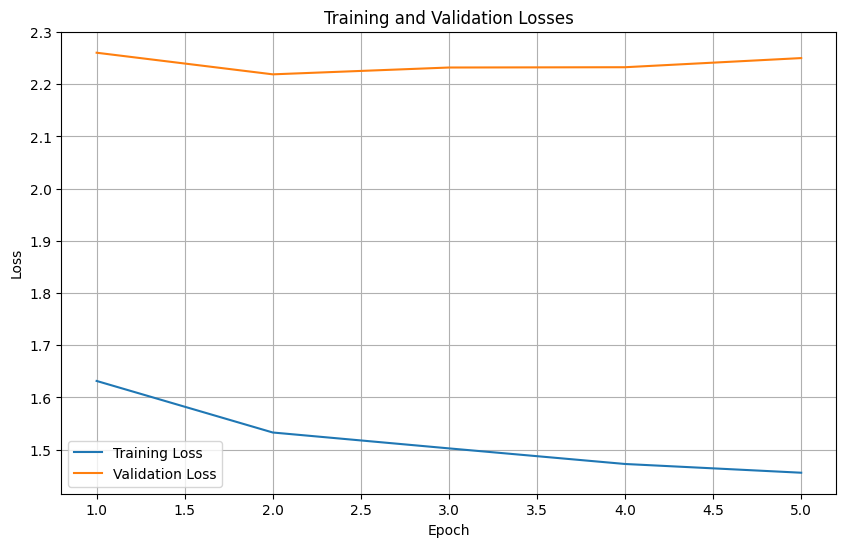


Training Summary:
Initial Training Loss: 1.6316
Final Training Loss: 1.4557
Best Training Loss: 1.4557

Initial Validation Loss: 2.2604
Final Validation Loss: 2.2501
Best Validation Loss: 2.2189


In [46]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [47]:
import torch

def evaluate_model(model, dataloader, device):
    """Evaluate the model and return predictions and labels for metric calculation."""
    model.eval()
    all_predictions = []
    all_labels = []

    print("\nEvaluating DataLoader...")
    total_samples = len(dataloader.dataset)
    print(f"Total samples in DataLoader: {total_samples}")

    with torch.no_grad():
        for batch_idx, (inputs, targets, impression_ids) in enumerate(dataloader):
            his_input_title, his_input_time, pred_input_title = inputs

            if batch_idx == 0:  # Debug first batch shapes
                print("\nFirst batch shapes:")
                print(f"  - his_input_title: {his_input_title.shape}")
                print(f"  - pred_input_title: {pred_input_title.shape}")
                print(f"  - targets: {targets.shape}")

            # Move data to device
            his_input_title = his_input_title.to(device)
            his_input_time = his_input_time.to(device)
            pred_input_title = pred_input_title.to(device)
            targets = targets.to(device)

            # Get predictions
            predictions = model.predict(his_input_title, his_input_time, pred_input_title)
            predictions = predictions.cpu().numpy()
            targets = targets.cpu().numpy()

            # Process each sample in the batch
            batch_size = predictions.shape[0]
            for sample_idx in range(batch_size):
                pred = predictions[sample_idx]
                label = targets[sample_idx]

                # Create valid_mask where label is not equal to the padding value (-1)
                valid_mask = (label != -1)
                sample_preds = pred[valid_mask]
                sample_labels = label[valid_mask]

                if len(sample_labels) == 0:
                    continue  # Skip empty samples

                # Ensure that there is at least one positive and one negative label
                if len(np.unique(sample_labels)) < 2:
                    continue  # Skip samples with only one class

                all_predictions.append(sample_preds.tolist())
                all_labels.append(sample_labels.tolist())

    print("\nEvaluation completed.")
    print(f"Total predictions generated: {len(all_predictions)}")
    print(f"First few prediction lengths: {[len(x) for x in all_predictions[:15]]}")
    return all_labels, all_predictions


# Evaluate the model
labels_list, scores_list = evaluate_model(model, val_dataloader_temp, device)

# Validate predictions against the DataFrame
print("\nValidation against DataFrame:")
if len(scores_list) != len(df_validation):
    print("WARNING: Length mismatch!")
    print(f"  - Number of predictions: {len(scores_list)}")
    print(f"  - Number of rows in DataFrame: {len(df_validation)}")

# Compute metrics
metrics = MetricEvaluator(
    labels=labels_list,
    predictions=scores_list,
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10)
    ],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)


Evaluating DataLoader...
Total samples in DataLoader: 24327

First batch shapes:
  - his_input_title: torch.Size([64, 50, 300])
  - pred_input_title: torch.Size([64, 88, 300])
  - targets: torch.Size([64, 88])

Evaluation completed.
Total predictions generated: 24327
First few prediction lengths: [40, 8, 13, 19, 21, 6, 6, 19, 13, 10, 6, 7, 16, 15, 9]

Validation against DataFrame:

Metrics: {'auc': 0.6064802675831172, 'mrr': 0.38268871112380837, 'ndcg@5': 0.42909395259438654, 'ndcg@10': 0.4991025940738092}


In [ ]:
print(f"FRACTION: {FRACTION}, HISTORY_SIZE: {HISTORY_SIZE}")

# Filter out special Python attributes and print parameters
params = {k: v for k, v in hparams_nrms_torch.__dict__.items() if not k.startswith('__')}
print("Hyperparameters:")
for key, value in params.items():
    print(f"{key}: {value}")

FRACTION: 0.1, HISTORY_SIZE: 40
Hyperparameters:
title_size: 24
embedding_dim: 32
word_emb_dim: 8
vocab_size: 10000
head_num: 4
head_dim: 8
attention_hidden_dim: 50
hidden_dim: 4
optimizer: adam
loss: cross_entropy_loss
dropout: 0.2
learning_rate: 0.0001
weight_decay: 0.001
news_output_dim: 64
units_per_layer: [64, 64, 64]


## Output Prediction File

In [ ]:
# Create dump directory
DUMP_DIR = Path("ebnerd_predictions")

# Create directory if it doesn't exist
DUMP_DIR.mkdir(parents=True, exist_ok=True)

# First rank the predictions
df_validation = df_validation.with_columns([
    pl.Series("scores", scores_list),
    pl.Series("labels", labels_list)
])

df_validation = df_validation.with_columns(
    pl.col("scores")
    .map_elements(lambda x: list(rank_predictions_by_score(x)))
    .alias("ranked_scores")
)

# Write submission file
write_submission_file(
    impression_ids=df_validation[DEFAULT_IMPRESSION_ID_COL],
    prediction_scores=df_validation["ranked_scores"],
    path=DUMP_DIR.joinpath("predictions.txt"),
    filename_zip=f"{DATASPLIT}_predictions-{MODEL_NAME}.zip",
)

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb